In [1]:
import copy
from enum import Enum
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import List

mi.set_variant("cuda_ad_rgb")
import autodiff
import threepoint

from mimt import *

class Setting(Enum):
    Direct = 1
    VaryingBRDF = 2
    IndirectIllumination = 3

In [2]:
def create_scene(setting: Setting, integrator: str):
    texture = create_gradient_image(128, 128, color_1=[1, 0, 0], color_2=[0, 1, 0])
    # texture = np.vstack([texture,texture,texture,texture,texture,texture,texture,texture,texture,texture])
    texture[:, :, 2] = 0.05

    scene_dict = {
        "type": "scene",

        "integrator": {
            "type": integrator,
            "max_depth": 2,
            "hide_emitters": False,
        },

        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = [0, 0,  0],
                target = [0, 0, -1],
                up=[0, 1, 0]
            ),
            "film": {
                "type": "hdrfilm",
                "rfilter": { "type": "gaussian" },
                "width": 128,
                "height": 128,
                "sample_border": False,
            },
            "sampler": { "type": "independent", "sample_count": 23**2, },
        },

        "surface_1": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = [0,  0, -1],
                target = [0, -1,  0],
                up=[0, 1, 0]
            ).scale(0.75),
        },

        "surface_2": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f.look_at(
                origin = [0, -2, -1],
                target = [0, 0,  -1],
                up=[0, 0, 1]
            ).scale(10),
            "emitter": { 
                "type": "area",
                "radiance": {
                    'type': 'bitmap',
                    'data': 2*texture,
                    'raw': True
                },
            }
        },
    }

    if setting == Setting.Direct:
        # Make the first surface an emitter and remove the second surface
        scene_dict["surface_1"]["emitter"] = scene_dict["surface_2"]["emitter"]
        del scene_dict["surface_2"]
    elif setting == Setting.VaryingBRDF:
        scene_dict["surface_1"]["bsdf"] = {
            "type": "diffuse",
            'reflectance': {
                'type': 'bitmap',
                'data': texture,
                'raw': True
            }
        }
        scene_dict["surface_2"]["emitter"]["radiance"] = {
            'type': 'rgb',
            'value': 2.0,
        }

    return scene_dict
    # scene_dict_overview = scene_dict.copy()
    # scene_dict_overview["sensor"] = scene_dict["sensor"].copy()
    # scene_dict_overview["sensor"]["to_world"] = mi.ScalarTransform4f.look_at(
    #     origin=[4, 4, 4], target=[0, 0, 0], up=[0, 1, 0]
    # )

def apply_transform(params: mi.SceneParameters, original: mi.Transform4f, offset: float):
    params['surface_1.to_world'] = mi.Transform4f.translate([0, 0, -offset]) @ original
    params.update()
    return params

def compute_gradient_finite_differences(func: callable, x: float, h: float = 0.01):
    return (func(x + h) - func(x - h)) / (2*h)

def compute_gradient_forward(func: callable, x: float):
    x_attached = mi.Float(x)
    dr.enable_grad(x_attached)

    output = func(x_attached)

    dr.set_grad(x_attached, 1)
    dr.forward_from(x_attached)
    return dr.grad(output)

In [3]:
# scene = mi.load_dict(create_scene(Setting.VaryingBRDF, integrator="ad_threepoint"))
# params   = mi.traverse(scene)
# original = mi.Transform4f(params['surface_1.to_world'])

# x_attached = mi.Float(1)
# dr.enable_grad(x_attached)

# render_with_offset = lambda x: mi.render(scene, params=apply_transform(params, original, x), seed=0)
# # render_with_offset = lambda x: render(scene, apply_transform(params, original, x))
# # Render primal image
# output = render_with_offset(x_attached)
# dr.set_grad(x_attached, 1)
# dr.forward_from(x_attached)
# print(output, dr.grad(output))
# plt.imshow(dr.grad(output))
# # plt.imshow(output)

In [4]:
def generate_data(integrators: List[str], settings: List[Setting]):
    data = {}

    # settings    = [Setting.Direct, Setting.VaryingBRDF, Setting.IndirectIllumination]
    # integrators = ["prb"]

    # Generate the data for the gi
    for setting in tqdm(settings):
        data[setting] = []

        for integrator in tqdm(integrators, leave=False):
            scene = mi.load_dict(create_scene(setting, integrator=integrator.lower()))

            params   = mi.traverse(scene)
            original = mi.Transform4f(params['surface_1.to_world'])

            # Render primal image
            img = mi.render(scene, params=params, seed=0)

            # Compute gradients
            render_with_offset = lambda x: mi.render(scene, params=apply_transform(params, original, x), seed=0)
            grad_fd = compute_gradient_finite_differences(render_with_offset, 0., h=0.001)
            grad_fw = compute_gradient_forward(render_with_offset, 0.)
            
            data[setting].append((integrator, img, grad_fd[...,0], grad_fw[...,0]))

    return data

def generate_figure(integrators: List[str], settings: List[Setting], data: dict, output_path: Path):
    n_rows = len(settings)
    n_cols = 2 + len(integrators)

    linewidth    = 237.13594/71.959
    figure_width = 2*linewidth
    aspect       = (n_rows / n_cols)
    fig = plt.figure(1, figsize=(figure_width, aspect * figure_width), constrained_layout=False)
    gs  = fig.add_gridspec(n_rows, n_cols, wspace=0.05, hspace=0.05)
    r = None
    for i, setting in enumerate(settings):
        setting_data = data[setting]
        for j, integrator in enumerate(integrators):
            print(setting_data[j][0], integrator)
            assert setting_data[j][0] == integrator
            if j == 0:
                # Show primal image
                ax_img = fig.add_subplot(gs[i, j])
                ax_img.imshow(mi.Bitmap(setting_data[j][1]).convert(srgb_gamma=True))
                disable_ticks(ax_img)
                
                # Show FD of reference primal image
                ax_fd = fig.add_subplot(gs[i, j + 1])
                # if r is None:
                r = np.quantile(np.abs(setting_data[j][2]), 0.99)
                if i == 2:
                    r = np.quantile(np.abs(setting_data[j][2]), 0.99)*2
                #r = np.maximum(r, 1)
                ax_fd.imshow(setting_data[j][2], cmap='coolwarm', vmin=-r, vmax=r)
                disable_ticks(ax_fd)

                if i == len(settings) - 1:
                    ax_img.set_xlabel("Image")
                    ax_fd.set_xlabel("FD")
                
                ax_img.set_ylabel(f"Setting {i+1}")

            # Show forward-mode gradient
            ax_fw = fig.add_subplot(gs[i, j + 2])
            ax_fw.imshow(setting_data[j][3], cmap='coolwarm', vmin=-r, vmax=r)
            disable_ticks(ax_fw)

            if i == len(settings) - 1:
                ax_fw.set_xlabel(f"{integrator}")

    plt.show()

    output_dir = output_path.parent
    output_dir.mkdir(exist_ok=True, parents=True)
    fig.savefig(output_path, facecolor='white', bbox_inches='tight')

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3491896..1.3008184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.29638004..1.191673].


prb prb
AD AD
ad_threepoint ad_threepoint
prb prb
AD AD
ad_threepoint ad_threepoint
prb prb
AD AD
ad_threepoint ad_threepoint


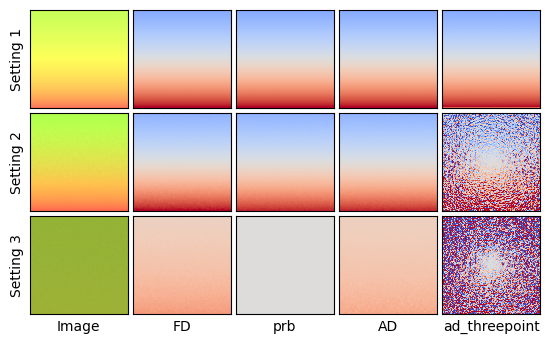

In [5]:
integrators = ["prb" , "prb_projective", "AD", "ad_threepoint" ]
integrators = ["prb", "AD", "ad_threepoint" ]
settings    = [Setting.Direct, Setting.VaryingBRDF, Setting.IndirectIllumination] # First two settings succeed with prb_reparam

data = generate_data(integrators, settings)
generate_figure(integrators, settings, data, Path("output/case_1.pdf"))

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3491897..1.3008184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.29638004..1.1916732].


prb prb
ad ad
prb prb
ad ad
prb prb
ad ad


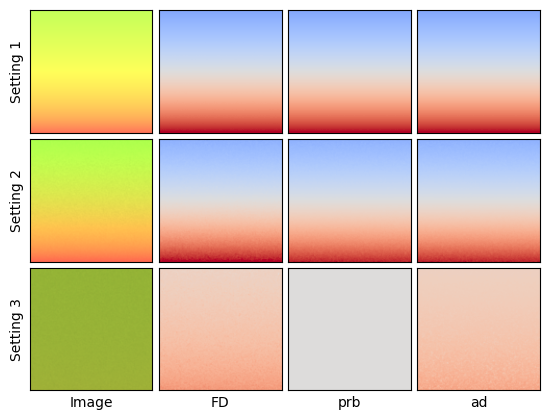

In [6]:
integrators = ["prb", "ad"]
settings    = [Setting.Direct, Setting.VaryingBRDF, Setting.IndirectIllumination]

data = generate_data(integrators, settings)
generate_figure(integrators, settings, data, Path("output/case_1_prb_vs_path.pdf"))